# APEX QTL calling pipeline
This notebook Document a prototype workflow for using the Apex to conduct analysis. It aims to replicate the workflow as shown in the following figures:

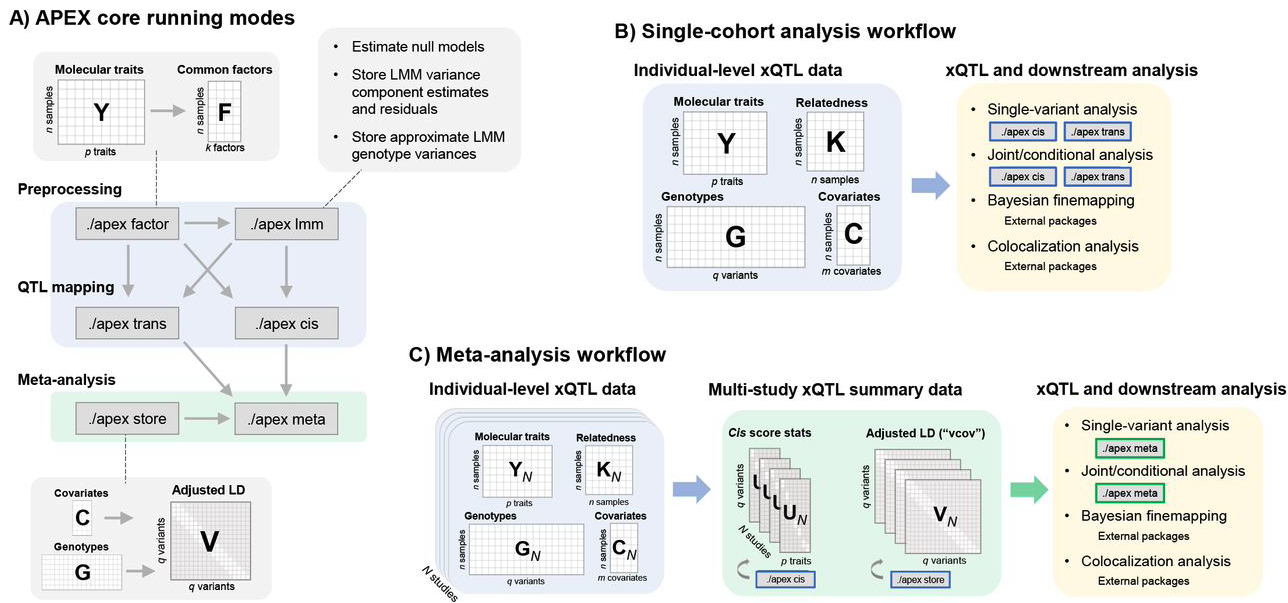

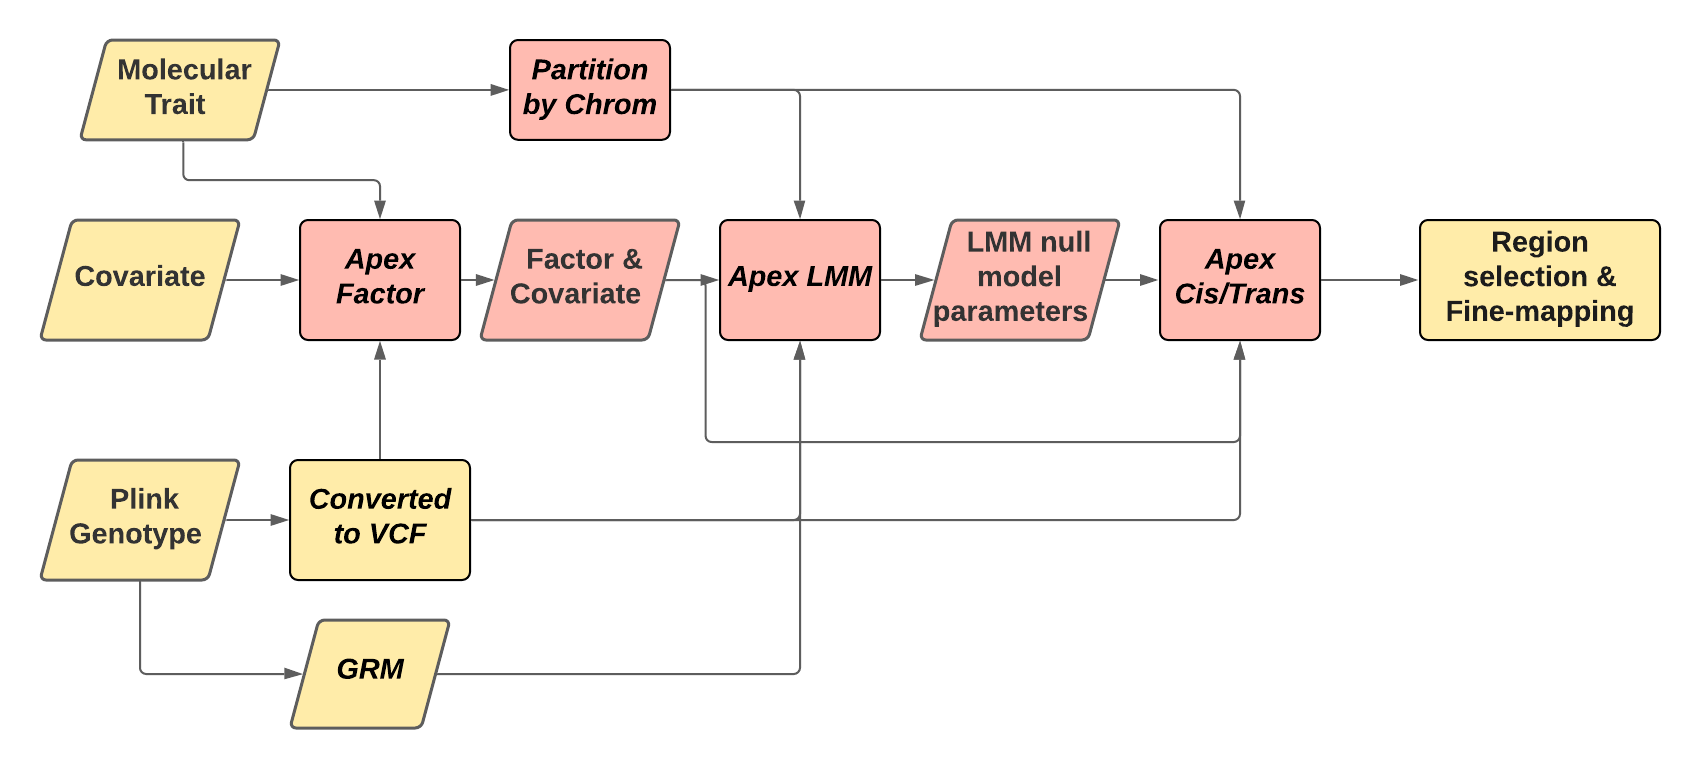

## Pre-requisites

This pipeline require the apex toolkits, tabix, bgzip, and R:Tidyverse. A singularity container is provided along with the mwe


# Input and Output
## Input
- `--molecular-pheno`, The text file containing the table describing the molecular phenotype. It shall have regions(genes) as rows and samples as columnes
- `--region_list` The text file with 4 columns specifying the #Chr, P0 (Start position), P1(End position) and names of regions to analyze. The name of the column is not important but the order of the columns. It is also important that the column name of the first column starts with a #. The region_list can can be generated by using another sos pipeline SOS_ROSMAP_gene_exp_processing.ipynb.


- `genotype_list` as the pipeline required whole genome vcf file for each chromosome, those vcf are converted beforehand from plink trio using the following commands:

```
for i in $(seq 1 22); do

plink --bfile /mnt/mfs/ctcn/datasets/rosmap/wgs/ampad/variants/snvCombined/plink_files/ROSMAP_chr$i \
--recode vcf-iid       --out ROSMAP_chr$i ;
bgzip ROSMAP_chr$i.vcf  ;
tabix -p vcf ROSMAP_chr$i.vcf.gz ;
tabix -H ROSMAP_chr$i.vcf.gz ;
echo $i;
done
```
## Correction:

```
for i in $(seq 1 22); do

plink --bfile /mnt/mfs/ctcn/datasets/rosmap/wgs/ampad/variants/snvCombinedPlink/chr$i \
--recode vcf-iid       --out ROSMAP_chr$i ;
bgzip ROSMAP_chr$i.vcf  ;
tabix -p vcf ROSMAP_chr$i.vcf.gz ;
tabix -H ROSMAP_chr$i.vcf.gz ;
echo $i;
done
```




- `grm_list` are a file containing list of grm matrixs that generated by the GRM module of this pipeline.



## Output





# Command interface 

In [3]:
!sos run ~/GIT/neuro-apex/apex/Apex_prototyping.ipynb -h

usage: sos run /home/hs3163/GIT/neuro-apex/apex/Apex_prototyping.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  Expression_Filtering
  apex_cis
  Factor_analysis
  LMM
  cis
  trans
  GRM

Global Workflow Options:
  --molecular-pheno-whole VAL (as path, required)
                        Path to the input molecular phenotype data.
  --ori-covariate ''
                        Covariate file, in similar format as the molecular_pheno
  --genotype-list VAL (as path, required)
                        List of Genotype file in plink trio format
  --region-list VAL (as path, required)
                        An index text file with 4 columns specifying the chr,
          

# Working example
please [download a minimal working example here](https://drive.google.com/file/d/1838xUOQuWTszQ0WJGXNiJMszY05cw3RS/view?usp=sharing), unzip the mwe file, and in the folder containing said folder run the following commands:

In [1]:
## Test pipeline with test data
## Switch back to abosolute path, otherwise there will be file not found error in step 5
nohup sos run ~/GIT/neuro-apex/apex/Apex_prototyping.ipynb apex_cis \
  --molecular_pheno_whole ./mwe/mole_pheno   \
  --wd ./ \
  --genotype_list ./mwe/mwe.genotype_list.txt \
  --region_list ./mwe/mwe_region \
  --iteration 2 \
  --container "./mwe/apex.sif" \
  --job_size 1 \
  --Prefix "MWE" \
  --grm_list "./mwe/grm/MWE.grm_list.txt" \
  -J 50 -q csg -c ~/GIT/neuro-twas/code/csg.yml &




ERROR: Failed to locate twas_fusion.ipynb.sos



# Global parameter settings
The section outlined the parameters that can be set in the command interface.

In [5]:
[global]
# Path to the input molecular phenotype file, per chrm, in bed.gz format.
parameter: molecular_pheno = path
# Covariate file, in similar format as the molecular_pheno
parameter: covariate = path
# Genotype file in vcf format, per chrm
parameter: genotype_file = path
genotype_list = genotype_file
# grm file in pairwise table format , per chrm
parameter: grm = path



# Path to the work directory of the analysis.
parameter: wd = path('./')
# Specify the number of jobs per run.
parameter: job_size = 2
# Container option for software to run the analysis: docker or singularity
parameter: container = ''
# Prefix for the analysis output
parameter: name = 'ROSMAP'


# Specify the scanning window for the up and downstream radius to analyze around the region of interest, in units of bp
parameter: window = ['1000000']



## LMM Regression  
This step are done to precompute and store a) LMM null models and trait residuals and b) spline terms for LMM genotypic variances to speed up downstream analysis

In [ ]:
[APEX_*_1,LMM]
input: molecular_pheno, genotype_file, covariate, grm
parameter: window = 100000
output: f'{wd:a}/{_input[0]:bnn}.theta.gz'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    apex lmm --vcf $[_input[1]] \
    --bed $[_input[0]] \
    --cov $[_input[2]] \
    --out $[_output[0]:nn] \
    --grm $[_input[3]] \
    --fit-null \
    --save-resid \
    --write-gvar
    

## QTL Sumstat generation  
This step generate the cis-QTL summary statistics and vcov (covariate-adjusted LD) files for downstream analysis from summary statistics. The analysis is done per chromosome to reduce running time.

In [ ]:
[APEX_cis_2,cis]
input: molecular_pheno, genotype_file, covariate, grm, output_from("LMM")
output:f'{_input[4]:nn}.cis_long_table.txt.gz',
       f'{_input[4]:nn}.cis_gene_table.txt.gz',
       f'{_input[4]:nn}.cis_sumstats.txt.gz'

task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '80G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    apex cis --vcf $[_input[1]] \
    --bed $[_input[0]] \
    --cov $[_input[2]] \
    --out $[_output[0]:nnn] \
    --grm  $[_input[3]] \
    --theta-file $[_input[4]] \
    --long

In [ ]:
[APEX_trans_2,trans]
parameter: keep_gene = ""
input: molecular_pheno, genotype_file, covariate, grm, output_from("LMM")
output: f'{_input[4]:nn}.trans_long_table.txt.gz',
        f'{_input[4]:nn}.trans_gene_table.txt.gz'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '40G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    apex trans --vcf $[_input[1]] \
    --bed $[_input[0]] \
    --cov $[_input[2]] \
    --out $[_output[0]]:nnn] \
    --grm  $[_input[3]] \
    --theta-file $[_input[4]] \
    --gene "$[keep_gene]" \
    --long

In [ ]:
[APEX_*_3]
output: f'{_input[0]:nn}.reformated.txt'
task: trunk_workers = 1, trunk_size = 1, walltime = '24h',  mem = '70G', tags = f'{step_name}_{_output[0]:bn}'
R: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{wd:ad}']
    library("dplyr")
    library("data.table")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    data <- read_delim("$[_input[0]]",delim = "\t")
    data = data%>%mutate(variant_id = pmap_chr(list(a = `#chrom`,b = pos,c = ref, d = alt),function(a,b,c,d) paste(c(a,":",b,"_",c,"_",d),collapse = "")))
    data = data%>%group_by(variant_id)%>%top_n(-1, abs(pval))
    data %>%write_delim("$[_output]",delim = "\t")